# Stackoverflow: basic analysis

![Screenshot](screenshot.png "The Stackoverflow website")

https://stackoverflow.com/ is a wonderful resource for people with a professional background in software development, beginners, or all intermediate levels. Users can ask detailed questions about topics related to software and software development. People with more experience in the topic will respond to those questions. This leads to fruitful discussions and interesting connections between users with different levels of expertise, and of course connections between different areas of software development.

The idea of the basic analysis in this notebook is to plot general values like the number of posts versus time, additionally split into different categories / tags.
The frequency of tags and the relation between those tags is of further interest. We want to also plot the network of tags in order to discover interesting connections and links (possible as a function of time).
The later goal of training tensorflow to predict good questions and responses with natural language processing will be attempted in a seperate notebook.

The data of posts, comments, etc from the stackoverflow website as well as all other stack exchange websites is openly available at https://archive.org/details/stackexchange under the CreativeCommons 3.0 license. We hereby indicate that proper reference to the source of the data was given.

All of the data is provided in 7zipped XML files with a clear and clean structure.
These huge XML files can be unzipped and read, or alternatively, iterated over directly in zipped form. We decided to start with the latter approach in order to not occupy too much disk space. Unzipping the files first, however, enables us to have more freedom in parallelizing the reading of data. This might need to be explored more at a later point.

The python library hosted at https://github.com/smartfile/python-libarchive provides an interface to libarchive written in C++. Using this library, we can open and iterative 7z files directly without unpacking them first.

The technical part of iterating over the zipped files and saving them out is done by a python module found here: https://github.com/AkagiShigeru/incubator-overflow/blob/master/stack_readin.py. Through the use of a generator to iterate over the entries in the file, the memory consumption is very low. The writing to the HDF file is done sequentielly. A certain chunk from memory is written and the memory is released.

For the purpose of some first insightful plots, we will start to analyse the subset of the first 5 million posts. These were written out into an hdf5 file and can be conveniently read with pandas and its interface to pytables. The total number of posts (questions + answers) in the stackoverflow dump is around 

In [33]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from pyik.mplext import ViolinPlot
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

We are using the PyIK library (https://github.com/HDembinski/pyik) for some special plots and analyses. We are co-authors of this nice library with some neat additions to numpy and matplotlib, specifically for fitting and data analysis.

In [3]:
# path to the hdf file containing the first 5M posts (posts or comments)
posts_path = "/home/alex/data/stackexchange/overflow/caches/posts_first5M.hdf5"

In [8]:
store = pd.HDFStore(posts_path, "r", complib="blosc", complevel=9)

# the hdf file containing posts was written in pytables tables format
# this optionally allows the user to query for a subset of the data on disk without ever loading all data into RAM

# select only questions
smask = store.select_as_coordinates("posts", "PostTypeId < 2")
posts = store.select("posts", where=smask)

In [24]:
print posts.shape
print posts.head()

(1522025, 23)
   AcceptedAnswerId  AnswerCount Body  BodyNQMarks  BodySize ClosedDate  \
0                 7           13                 0       662        NaT   
1                31            5                 3       978        NaT   
3              1404           60                 1       140        NaT   
4              1248           33                 0       265        NaT   
6                -1           24                 2       188        NaT   

   CommentCount      CommunityOwnedDate            CreationDate  \
0             5 2012-10-31 16:42:47.213 2008-07-31 21:42:52.667   
1             0                     NaT 2008-07-31 22:08:08.620   
3             8 2011-08-16 19:40:43.080 2008-07-31 23:40:59.743   
4             3 2009-09-04 13:15:59.820 2008-07-31 23:55:37.967   
6             3                     NaT 2008-08-01 00:42:38.903   

   FavoriteCount    ...      LastEditorDisplayName LastEditorUserId  \
0             37    ...                     Rich B           

In [25]:
posts.columns
dates = ["ClosedDate", "CommunityOwnedDate", "CreationDate", "LastActivityDate", "LastEditDate"]

In [26]:
# convert creation date to pandas datetime
for date in dates:
    posts[date] = pd.to_datetime(posts[date])

In [27]:
posts.tail()

,AcceptedAnswerId,AnswerCount,Body,BodyNQMarks,BodySize,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,...,LastEditorDisplayName,LastEditorUserId,OwnerDisplayName,OwnerUserId,ParentId,PostTypeId,Score,Tags,Title,ViewCount
199993,6034133,1,,0,394,NaT,0,NaT,2011-05-17 16:25:35.593,-1,...,,210916,,131050,-1,1,5,;node.js;connect;express,Connect session middleware - regenerate vs reload,1742
199996,6034065,1,,1,187,NaT,2,NaT,2011-05-17 16:25:37.787,-1,...,,436641,,590898,-1,1,0,;android;google-maps,How can I use Google Maps to let people see ea...,529
199997,6035228,1,,2,803,NaT,2,NaT,2011-05-17 16:25:42.970,-1,...,,592301,,592301,-1,1,0,;html5;silverlight-4.0;richtextbox;contentedit...,HTML5 Equivalent to Silverlight RichTextBox?,1648
199998,6034142,2,,0,1622,NaT,0,NaT,2011-05-17 16:25:47.757,-1,...,,-1,,604876,-1,1,0,;java;mysql;jboss;entity,insertupdate sql mysql and jpa entity,1531
199999,6034829,2,,3,667,NaT,0,NaT,2011-05-17 16:25:53.373,1,...,,-1,,169867,-1,1,3,;entity-framework;entity-framework-4;entity,Why is the TableAttribute in the Entity Framew...,3258


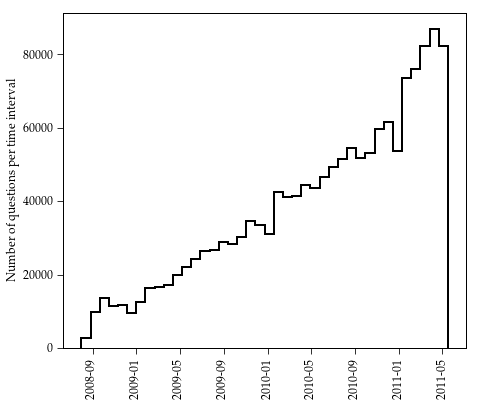

In [52]:
# plot a histogram of the overall number of questions vs. time
plt.figure()
plt.ylabel(r"Number of questions per time interval")
posts.CreationDate.hist(grid=False, xrot=90, figsize=(8, 6), histtype="step", color="black", lw=2, bins=40)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%.0f"))

0    Thursday
1    Thursday
3    Thursday
4    Thursday
6      Friday
Name: CreationDate, dtype: object
0    3
1    3
3    3
4    3
6    4
Name: CreationDate, dtype: int64


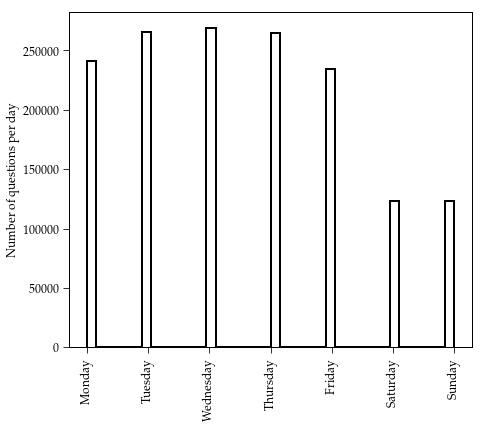

In [81]:
# what about the day of the week?
print posts.CreationDate.dt.weekday_name.head()
print posts.CreationDate.dt.weekday.head()
plt.figure()
plt.ylabel(r"Number of questions per day")
posts.CreationDate.dt.weekday.hist(grid=False, xrot=90, figsize=(8, 6), histtype="step", color="black", lw=2, bins=40)
plt.gca().set_xticklabels(["", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%.0f"))

In [47]:
# testing for different tags, e.g. python
print "Number of questions related to Python", np.sum(posts.Tags.str.lower().str.contains("python"))
print "Number of questions related to C++", np.sum(posts.Tags.str.lower().str.contains("c\+\+"))
print "Number of questions related to Java", np.sum(posts.Tags.str.lower().str.contains("java"))
print "Number of questions related to SQL", np.sum(posts.Tags.str.lower().str.contains("sql"))
print "Number of questions related to Bash", np.sum(posts.Tags.str.lower().str.contains("bash"))

Number of questions related to Python 58422
Number of questions related to C++ 73010
Number of questions related to Java 215200
Number of questions related to SQL 127350
Number of questions related to Bash 5773


In [51]:
# importing a few utilties
from stack_util import *
tags = ["Python", "C\+\+", "Java", "SQL", "Bash"]

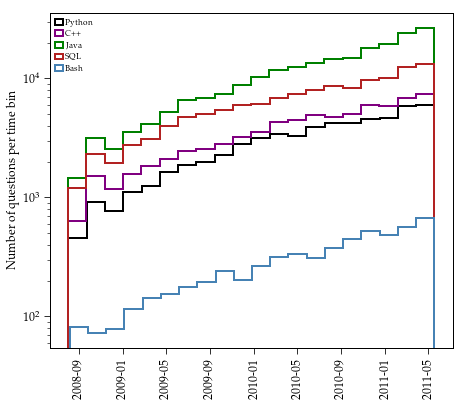

In [66]:
# plot a histogram of posts vs. time for those selected tags
# plot a histogram of the overall number of questions vs. time
plt.figure()
plt.ylabel(r"Number of questions per time bin")
for i, tag in enumerate(tags):
    tagposts = posts[posts.Tags.str.lower().str.contains(tag.lower())]
    tagposts.CreationDate.hist(grid=False, xrot=90, figsize=(8, 6), 
                               histtype="step", color=g_carr[i], lw=2, bins=20, 
                               label="%s" % tag.replace("\\",""))
#plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%.0f"))
plt.semilogy(nonposy="clip")
plt.legend(loc="upper left")

In [ ]:
# what if we want to normalize with respect to the overall number of questions (to better see trend)?